In [1]:
%pip install -q matplotlib pandas numpy scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.metrics import r2_score

In [3]:
df = pd.read_csv("6V_all-axis_fast.txt", sep=r"\s+", header=None)

df.columns = [
    "timestep",
    "x_in", "x_in_scaled",
    "y_in", "y_in_scaled",
    "z_in", "z_in_scaled",
    "x_out", "y_out", "z_out"
]
file_format = df.columns

print(df.head(10))
print("Shape:", df.shape)

     timestep        x_in  x_in_scaled        y_in  y_in_scaled       z_in  \
0  4226439499    0.000000            0    0.000000            0   0.000000   
1  4226439500  166.909218     10938562  177.002152     11600013  16.229296   
2  4226439501  167.976277     11008493  177.382261     11624923  13.580543   
3  4226439502  169.025740     11077270  177.786055     11651386  10.939399   
4  4226439503  170.057600     11144894  178.213424     11679394   8.306029   
5  4226439504  171.071854     11211365  178.664255     11708940   5.680600   
6  4226439505  172.068498     11276681  179.138427     11740015   3.063275   
7  4226439506  173.047532     11340843  179.635819     11772613   0.454220   
8  4226439507  174.008957     11403850  180.156305     11806723  -2.146402   
9  4226439508  174.952776     11465705  180.699753     11842339  -4.738428   

   z_in_scaled     x_out         y_out       z_out  
0            0  7491.712 -7.662780e+13 -633441.408  
1      1063603  7505.280 -7.662799e

Try doing a simple windowed regression in sklearn. Then try auto ml once the data is prepared right.

0.7830501260396103


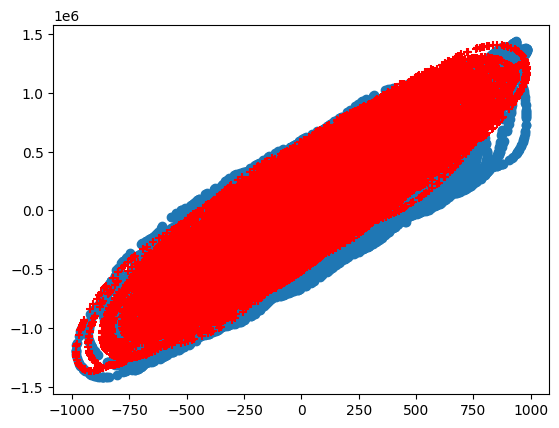

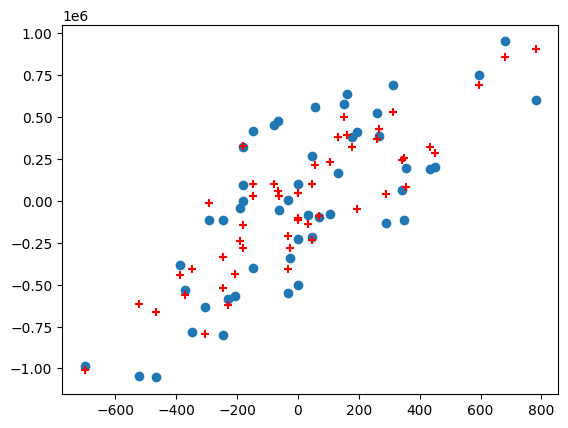

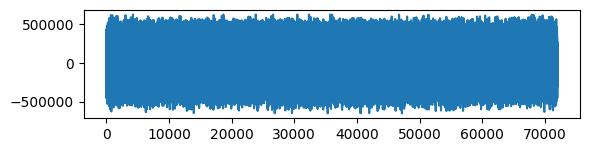

In [4]:

WINDOW_LEN = 3

x_in = df["x_in"].values.reshape(360001, 1)
x_in.setflags(write=False)
x_out = df["x_out"].values.reshape(360001, 1)

x_in_window = sliding_window_view(x_in, WINDOW_LEN, 0)
x_in_window = np.squeeze(x_in_window)
x_out_truncated = np.delete(x_out, slice(0,WINDOW_LEN-1))

def windowed_linear_regression(x_in_window, x_out_truncated):

    regressor = LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(x_in_window, x_out_truncated, test_size=0.2, random_state=42)

    regressor.fit(X_train,y_train)
    y_pred = regressor.predict(X_test)

    print(r2_score(y_test, y_pred))


    plt.scatter(X_test[:, -1], y_test[:], )
    plt.scatter(X_test[:, -1], y_pred[:], color="red", marker="+")
    plt.show()

    plt.scatter(X_test[:50,-1], y_test[:50], )
    plt.scatter(X_test[:50, -1], y_pred[:50], color="red", marker="+")
    plt.show()
    
    plt.subplot(3,1,3)
    plt.plot(y_pred-y_test)

windowed_linear_regression(x_in_window,x_out_truncated)

The plot is no longer useful i guess the best plot would track a path through the space.

-4.2044611186176084e-05


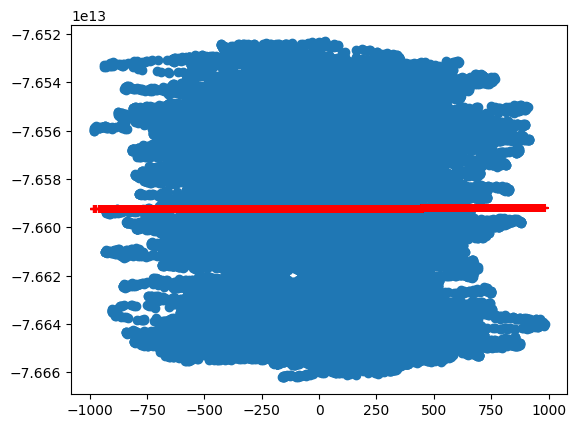

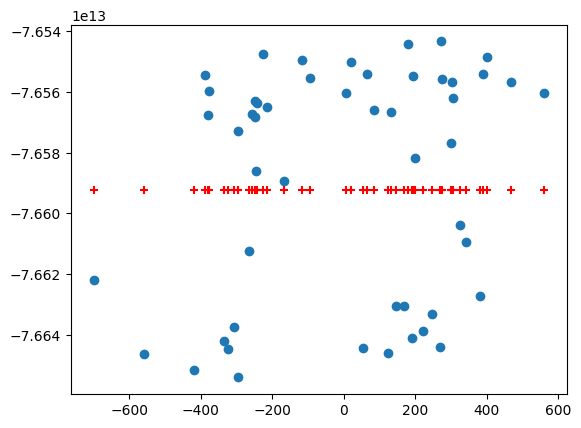

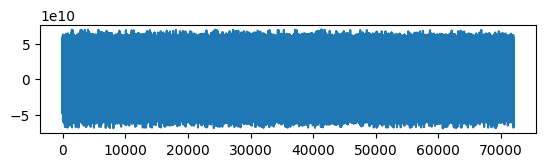

In [5]:
y_in = df["y_in"].values.reshape(360001, 1)
y_in.setflags(write=False)
y_out = df["y_out"].values.reshape(360001, 1)


y_in_window = sliding_window_view(y_in, WINDOW_LEN, 0)
y_in_window = np.squeeze(y_in_window)
y_out_truncated = np.delete(y_out, slice(0,WINDOW_LEN-1))

windowed_linear_regression(y_in,y_out)

What if we can show a deviation

0.45638351267080934


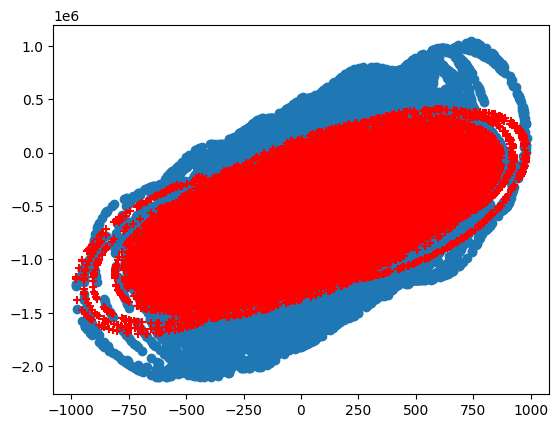

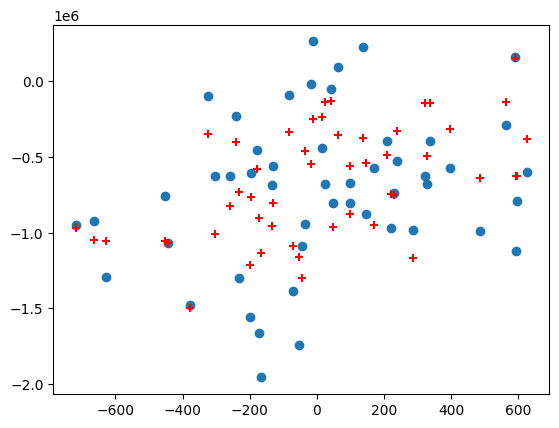

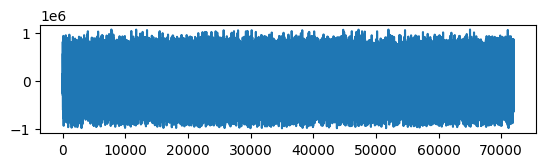

In [6]:
z_in = df["z_in"].values.reshape(360001, 1)
z_in.setflags(write=False)
z_out = df["z_out"].values.reshape(360001, 1)


z_in_window = sliding_window_view(z_in, WINDOW_LEN, 0)
z_in_window = np.squeeze(z_in_window)
z_out_truncated = np.delete(z_out, slice(0,WINDOW_LEN-1))

windowed_linear_regression(z_in_window,z_out_truncated)

Try all 3 dims at once

0.4980142951592523
(287999, 9) (72000, 3)


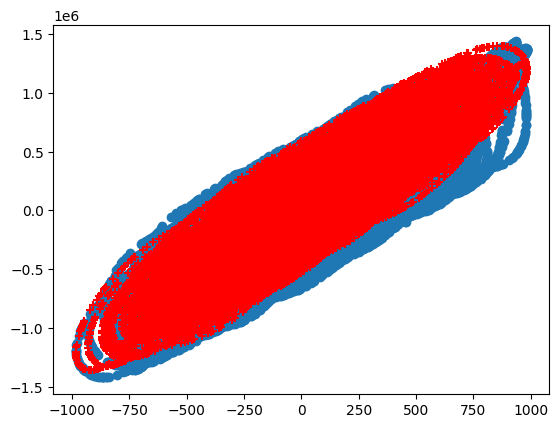

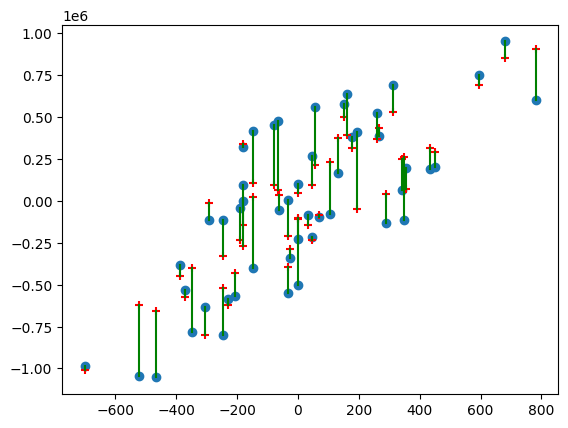

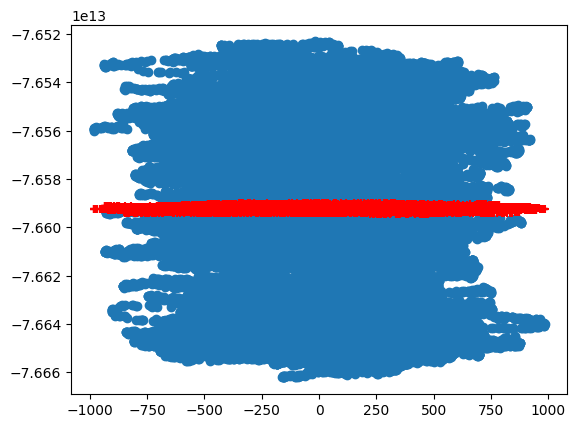

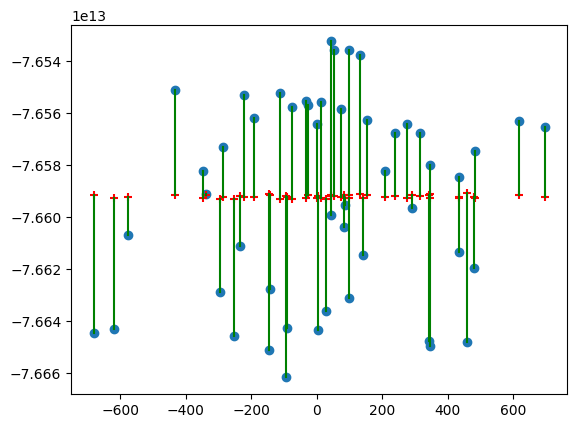

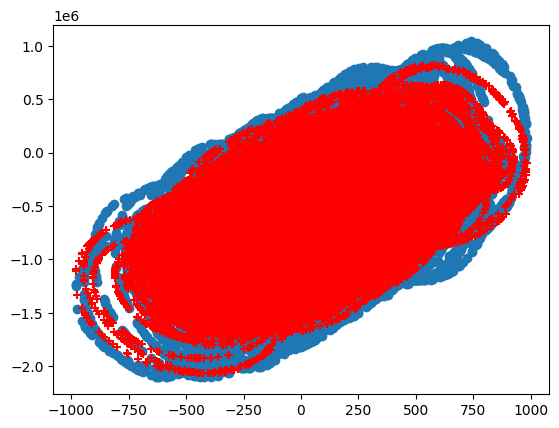

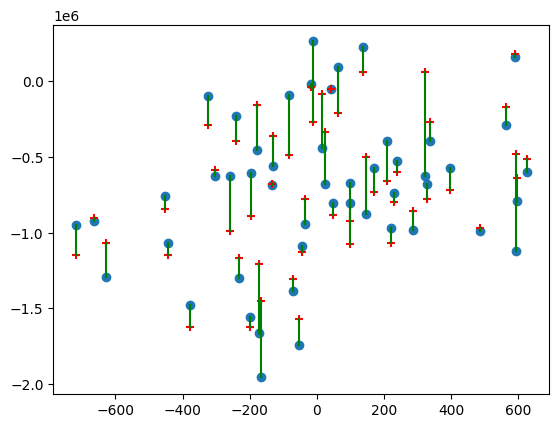

In [7]:

all_data_in = np.concatenate([x_in_window,y_in_window,z_in_window], axis=1)
all_data_out = np.stack([x_out_truncated, y_out_truncated, z_out_truncated], axis=1)

regressor = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(all_data_in, all_data_out, test_size=0.2, random_state=42)

regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)

print(r2_score(y_test, y_pred))

print(X_train.shape, y_test.shape)

def create_scatter_plots(dims):
    
    for i in range(dims):

        x_plot = X_test[:, i*WINDOW_LEN + WINDOW_LEN - 1]

        plt.scatter(x_plot, y_test[:,i], )
        plt.scatter(x_plot, y_pred[:,i], color="red", marker="+")
        plt.show()

        x_plot = X_test[:50, i*WINDOW_LEN + WINDOW_LEN- 1]
        plt.scatter(x_plot, y_test[:50, i], )
        plt.scatter(x_plot, y_pred[:50, i], color="red", marker="+")

        for j in range(len(x_plot)):
            plt.plot([x_plot[j], x_plot[j]], [y_test[:50, i][j], y_pred[:50, i][j]], color='green')
        plt.show()

create_scatter_plots(3)


Try just x and z

0.7460807700637369


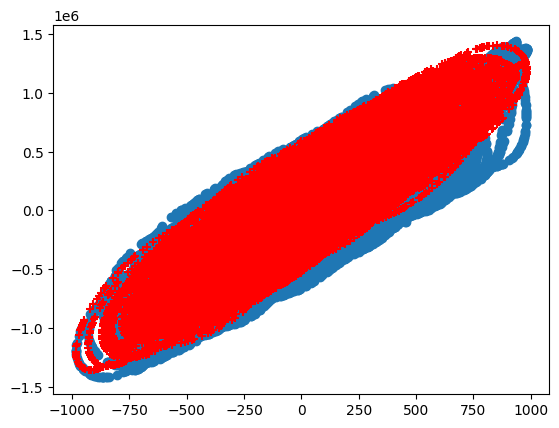

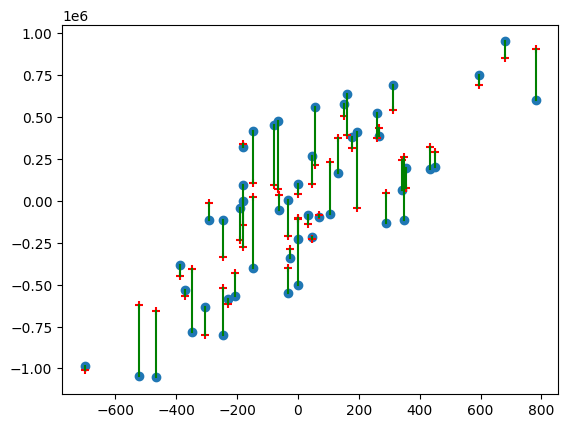

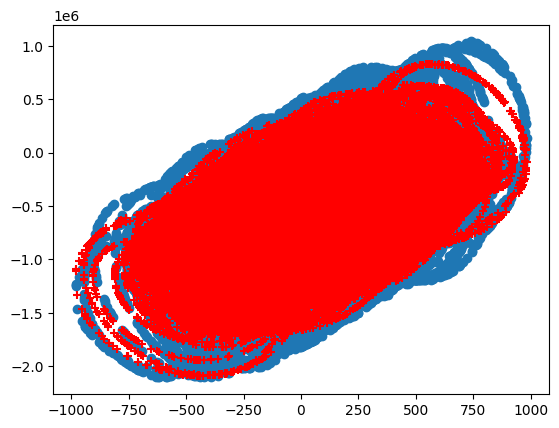

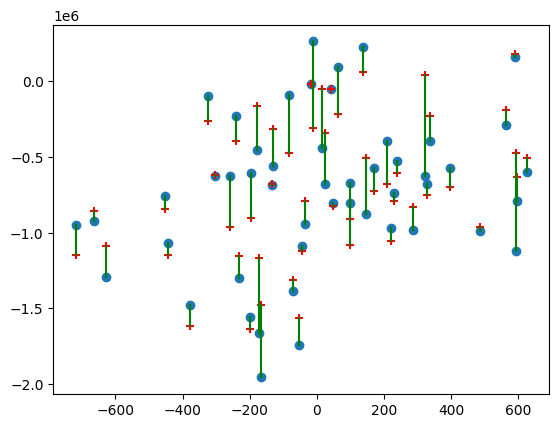

In [8]:

xz_data_in = np.concatenate([x_in_window, z_in_window], axis=1)
xz_data_out = np.stack([x_out_truncated, z_out_truncated], axis=1)

regressor = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(xz_data_in, xz_data_out, test_size=0.2, random_state=42)

regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)

print(r2_score(y_test, y_pred))

create_scatter_plots(2)

In [9]:
# try time-series split instead of a random split
tscv = TimeSeriesSplit(n_splits=5)
r2_scores = []
r2_scores_weighted = []
r2_x_axis_scores = []
r2_z_axis_scores = []

for train_idx, test_idx in tscv.split(xz_data_in):
    X_train, X_test = xz_data_in[train_idx], xz_data_in[test_idx]
    y_train, y_test = xz_data_out[train_idx], xz_data_out[test_idx]

    regressor = LinearRegression()
    regressor.fit(X_train, y_train)

    y_pred = regressor.predict(X_test)
    r2_scores.append(r2_score(y_test, y_pred))
    r2_scores_weighted.append(r2_score(y_test, y_pred, multioutput="variance_weighted"))    
    r2_x_axis_scores.append(r2_score(y_test[:, 0], y_pred[:, 0]))
    r2_z_axis_scores.append(r2_score(y_test[:, 1], y_pred[:, 1]))

print("Mean R2 score with a time-series split:", np.mean(r2_scores))
print("Mean R2 score weighted with a time-series split:", np.mean(r2_scores_weighted))
print("Mean R2 score [X axis] with a time-series split:", np.mean(r2_x_axis_scores))
print("Mean R2 score [Z axis] with a time-series split:", np.mean(r2_z_axis_scores))

Mean R2 score with a time-series split: 0.7455663346403114
Mean R2 score weighted with a time-series split: 0.744351463012644
Mean R2 score [X axis] with a time-series split: 0.780454703689869
Mean R2 score [Z axis] with a time-series split: 0.7106779655907538
